# This notebook goes with Lesson 5, section 9 of the Tensorflow 2.0 course on Udacity. In it, we will create a model that classifies pictures of dogs vs. cats.

As usual, the first thing to do is to import the libraries. We need tensorflow, and ImageDataGenerator from tensorlow.keras.preprocessing.image, as well as the usual numpy, matplotlib.pylot, os, and logging.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load the Data

We need to load the dataset. It is a filtered version of the Dogs vs. Cats dataset from Kaggle, provided by Microsoft Research. So remember, we can use this stuff on Kaggle datasets.

In [2]:
_URL =  'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

This is the structure of the dataset we just downloaded, which is a folder full of pictures of cats and dogs.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Let's make the notebook print out the directories using terminal commands.

In [3]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


Haha! It worked! 

So, in the main folder there is a train folder and a validation folder, each containing a folder called dogs and another called cats. You can guess what might be in each folder.

Now we can add the training and validation sets to variables.

In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Understand the data

I have never dealt with a dataset like this, as a folder full of files rather than as a DataFrame or similar. Exploring this dataset will be different.

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print("Total training cat images: ", num_cats_tr)
print("Total training dog images: ", num_dogs_tr)
print("Total validation cat images: ", num_cats_val)
print("Total validation dog images: ", num_dogs_val)
print("-----")
print("Total training images: ", total_train)
print("Total validation images: ", total_val)

Total training cat images:  1000
Total training dog images:  1000
Total validation cat images:  500
Total validation dog images:  500
-----
Total training images:  2000
Total validation images:  1000


### Set Model Parameters

We are going to go ahead and set up the model parameters, such as batch size and image shape now. The images will be forced into the correct shape as part of the model.

In [7]:
BATCH_SIZE = 100
IMG_SHAPE = 150

## Prepare the Data

We need to read the images from the disk, then decode the contents of the images into a 3D grid, convert them into floating point tensors, then rescale the tensors between 0 and 1.

All of this is done with the ImageDataGenerator from tensorflow.keras.preprocessing.image

In [8]:
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

Now load the images from the disk.

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

validation_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Visual some Training Images

We will use matplotlib.pyplot for this. But we will need a user-defined function. Cool.

The *next* function returns a batch of images from the training set, and we are just keeping the images and not the labels.

In [10]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install Pillow
!{sys.executable} -m pip install --upgrade tensorflow
!{sys.executable} -m pip install --upgrade keras

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [11]:
from PIL import Image

In [12]:
sample_training_images, _ = next(train_data_gen)

Fuck it whatever. Let's just move on. Oh wait it is working now.

In [13]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


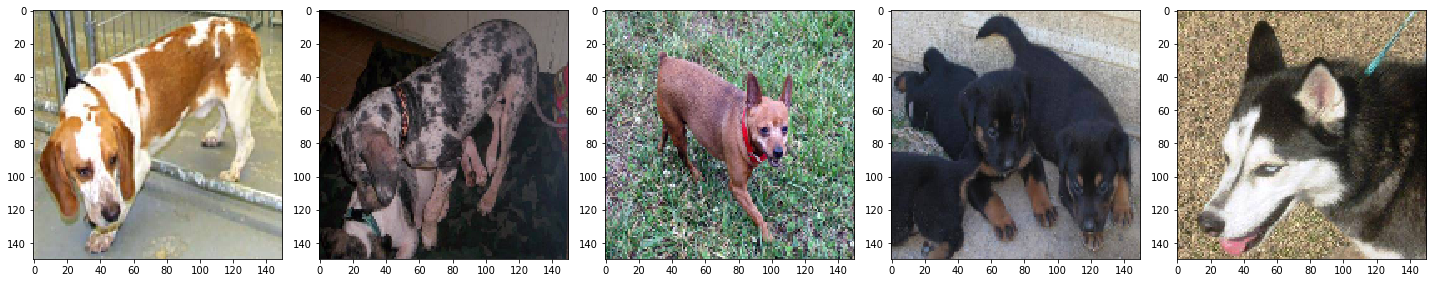

In [14]:
plotImages(sample_training_images[:5])

## Make the Model

### Define the model

We will use a bunch of layers here. There will be 4 2D convolutional layers with MaxPooling, then we Flatten and then 2 Dense layers. Activation will be 'relu' in every layer. 

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Compile the model

Now to compile. We will use the Adam optimizer. Still the only one I have used. We will use Sparse Categorical Cross-Entropy for the loss function and Accuracy as a metric.

In [16]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

Have a look at the model summary.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Excellent. This shows us the layers, tells us what the output looks like, and says how many parameters are in each layer. Deep Neural Networks overparameterize and then normalize. That's what Chris Oates said earlier, at least.

### Train the model

Since we used ImageDataGenerator, we need to use fit_generator instead of just fit.

In [18]:
EPOCHS = 100
history = model.fit_generator(train_data_gen,
                             steps_per_epoch=int(np.ceil(total_train/float(BATCH_SIZE))),
                             epochs=EPOCHS,
                             validation_data = validation_data_gen,
                             validation_steps=int(np.ceil(total_val/float(BATCH_SIZE))))

Epoch 1/100
20/20 [==============================] - 29s 1s/step - loss: 0.7343 - accuracy: 0.5070 - val_loss: 0.6925 - val_accuracy: 0.5420
Epoch 2/100
20/20 [==============================] - 28s 1s/step - loss: 0.6932 - accuracy: 0.5180 - val_loss: 0.6897 - val_accuracy: 0.5120
Epoch 3/100
20/20 [==============================] - 28s 1s/step - loss: 0.6899 - accuracy: 0.5360 - val_loss: 0.6779 - val_accuracy: 0.6110
Epoch 4/100
20/20 [==============================] - 28s 1s/step - loss: 0.6742 - accuracy: 0.5730 - val_loss: 0.6656 - val_accuracy: 0.5550
Epoch 5/100
20/20 [==============================] - 28s 1s/step - loss: 0.6554 - accuracy: 0.6245 - val_loss: 0.6824 - val_accuracy: 0.5330
Epoch 6/100
20/20 [==============================] - 28s 1s/step - loss: 0.6348 - accuracy: 0.6545 - val_loss: 0.6141 - val_accuracy: 0.6670
Epoch 7/100
20/20 [==============================] - 28s 1s/step - loss: 0.5713 - accuracy: 0.6980 - val_loss: 0.5938 - val_accuracy: 0.6830
Epoch 8/100
2

It takes a while to run for 100 Epochs. Also, notice that the training accuracy is perfect, while the validation accuracy is only around 75%. This is a clear case of overfitting. Hopefully we learn a better way to do this soon!

### Visualize Results

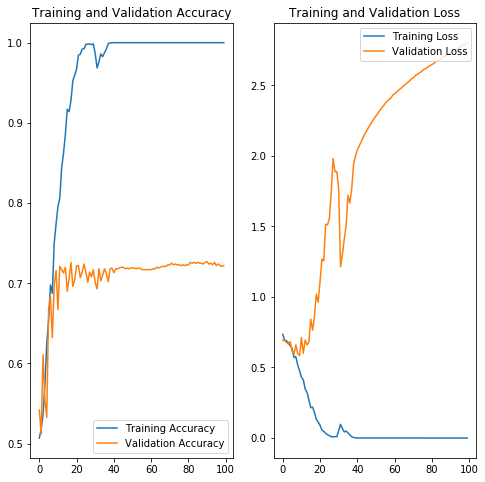

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

See? That ain't no good.